# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


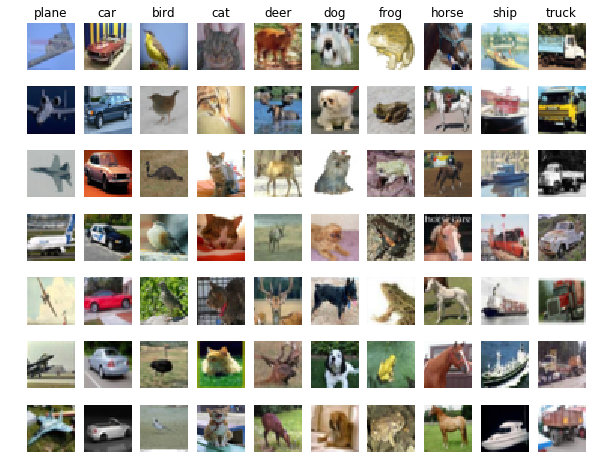

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


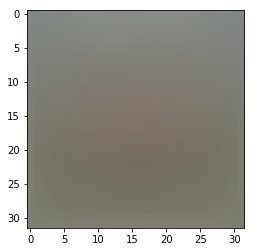

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.752465


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -24.041454 analytic: -24.041454, relative error: 5.013324e-12
numerical: 5.535798 analytic: 5.535798, relative error: 6.054113e-11
numerical: -46.277471 analytic: -46.277471, relative error: 5.995340e-12
numerical: -12.928857 analytic: -12.928857, relative error: 3.351016e-11
numerical: 11.945250 analytic: 11.945250, relative error: 6.993450e-12
numerical: 17.070104 analytic: 17.070104, relative error: 3.343422e-12
numerical: 2.170469 analytic: 2.170469, relative error: 2.039223e-10
numerical: 11.354874 analytic: 11.354874, relative error: 8.440800e-12
numerical: -9.667783 analytic: -9.667783, relative error: 6.743868e-11
numerical: -9.050310 analytic: -9.050310, relative error: 1.417298e-11
numerical: -23.277776 analytic: -23.271902, relative error: 1.262061e-04
numerical: -12.714242 analytic: -12.723712, relative error: 3.722925e-04
numerical: 18.398658 analytic: 18.401601, relative error: 7.997004e-05
numerical: -15.126114 analytic: -15.117502, relative error: 2.847681e-0

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *Gradcheck not match exactly when we don't have paritial derivative for all dimensions. Then analytic gradient won't exist.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.752465e+00 computed in 0.147385s
Vectorized loss: 8.752465e+00 computed in 0.010286s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.169568s
Vectorized loss and gradient: computed in 0.004596s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 784.960656
iteration 100 / 1500: loss 468.506010
iteration 200 / 1500: loss 284.926433
iteration 300 / 1500: loss 173.557443
iteration 400 / 1500: loss 106.248238
iteration 500 / 1500: loss 66.037904
iteration 600 / 1500: loss 41.778803
iteration 700 / 1500: loss 27.897116
iteration 800 / 1500: loss 18.468812
iteration 900 / 1500: loss 13.242553
iteration 1000 / 1500: loss 10.433445
iteration 1100 / 1500: loss 8.993239
iteration 1200 / 1500: loss 6.839766
iteration 1300 / 1500: loss 6.708232
iteration 1400 / 1500: loss 6.126813
That took 6.625392s


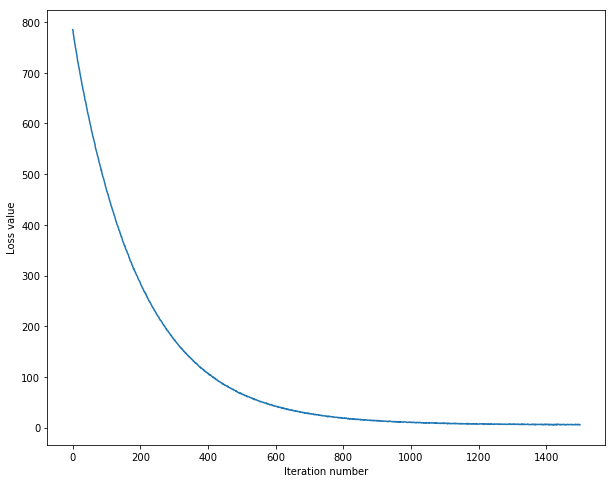

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.382122
validation accuracy: 0.398000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
# learning_ratest = np
import itertools as it

learning_rates = np.logspace(-9, -5, num=9)
regularization_strengths = np.logspace(2, 6, num=13)
combs = it.product(learning_rates, regularization_strengths)
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# pass
for lr, reg in combs:
    print(lr, reg)
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=1500, verbose=True)
    y_train_pred = svm.predict(X_train)
    y_val_pred = svm.predict(X_val)
    
    train_acc = np.mean(y_train == y_train_pred)
    val_acc = (np.mean(y_val == y_val_pred))

    results[(lr, reg)] = (train_acc, val_acc)
    if best_val < val_acc:
        best_val = val_acc
        best_svm = svm
        best_lr = lr
        best_reg = reg

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-09 100.0
iteration 0 / 1500: loss 22.174688
iteration 100 / 1500: loss 21.656028
iteration 200 / 1500: loss 21.359387
iteration 300 / 1500: loss 18.991576
iteration 400 / 1500: loss 20.134863
iteration 500 / 1500: loss 19.988504
iteration 600 / 1500: loss 19.895054
iteration 700 / 1500: loss 21.218763
iteration 800 / 1500: loss 18.742514
iteration 900 / 1500: loss 19.045157
iteration 1000 / 1500: loss 20.766012
iteration 1100 / 1500: loss 18.499357
iteration 1200 / 1500: loss 15.784464
iteration 1300 / 1500: loss 20.115335
iteration 1400 / 1500: loss 18.764128
1e-09 215.443469003
iteration 0 / 1500: loss 29.177912
iteration 100 / 1500: loss 28.722801
iteration 200 / 1500: loss 24.763914
iteration 300 / 1500: loss 25.878411
iteration 400 / 1500: loss 24.550747
iteration 500 / 1500: loss 24.131706
iteration 600 / 1500: loss 22.669756
iteration 700 / 1500: loss 25.238755
iteration 800 / 1500: loss 24.224396
iteration 900 / 1500: loss 24.260891
iteration 1000 / 1500: loss 22.479008
iter

iteration 1300 / 1500: loss 17.096011
iteration 1400 / 1500: loss 17.347201
3.16227766017e-09 215.443469003
iteration 0 / 1500: loss 25.719689
iteration 100 / 1500: loss 25.059759
iteration 200 / 1500: loss 24.558501
iteration 300 / 1500: loss 23.021010
iteration 400 / 1500: loss 22.351160
iteration 500 / 1500: loss 22.128511
iteration 600 / 1500: loss 22.209583
iteration 700 / 1500: loss 20.589887
iteration 800 / 1500: loss 21.012600
iteration 900 / 1500: loss 19.273931
iteration 1000 / 1500: loss 19.377854
iteration 1100 / 1500: loss 19.093166
iteration 1200 / 1500: loss 20.033439
iteration 1300 / 1500: loss 20.257849
iteration 1400 / 1500: loss 19.308991
3.16227766017e-09 464.158883361
iteration 0 / 1500: loss 35.748719
iteration 100 / 1500: loss 35.658766
iteration 200 / 1500: loss 32.880221
iteration 300 / 1500: loss 32.453508
iteration 400 / 1500: loss 28.628044
iteration 500 / 1500: loss 29.346838
iteration 600 / 1500: loss 30.624678
iteration 700 / 1500: loss 29.235707
iteratio

iteration 800 / 1500: loss 16.665571
iteration 900 / 1500: loss 18.401053
iteration 1000 / 1500: loss 18.714896
iteration 1100 / 1500: loss 17.242228
iteration 1200 / 1500: loss 18.186338
iteration 1300 / 1500: loss 16.640134
iteration 1400 / 1500: loss 15.578440
1e-08 464.158883361
iteration 0 / 1500: loss 38.210020
iteration 100 / 1500: loss 29.715232
iteration 200 / 1500: loss 30.625095
iteration 300 / 1500: loss 29.214900
iteration 400 / 1500: loss 28.312065
iteration 500 / 1500: loss 27.315975
iteration 600 / 1500: loss 27.208721
iteration 700 / 1500: loss 25.718916
iteration 800 / 1500: loss 26.220000
iteration 900 / 1500: loss 26.641671
iteration 1000 / 1500: loss 25.408113
iteration 1100 / 1500: loss 24.857173
iteration 1200 / 1500: loss 24.575704
iteration 1300 / 1500: loss 24.389452
iteration 1400 / 1500: loss 26.075994
1e-08 1000.0
iteration 0 / 1500: loss 55.476317
iteration 100 / 1500: loss 50.597974
iteration 200 / 1500: loss 46.827793
iteration 300 / 1500: loss 45.428146

iteration 800 / 1500: loss 24.022031
iteration 900 / 1500: loss 21.691445
iteration 1000 / 1500: loss 21.748840
iteration 1100 / 1500: loss 21.829532
iteration 1200 / 1500: loss 22.299302
iteration 1300 / 1500: loss 22.103079
iteration 1400 / 1500: loss 19.876543
3.16227766017e-08 1000.0
iteration 0 / 1500: loss 51.320155
iteration 100 / 1500: loss 46.211026
iteration 200 / 1500: loss 41.675909
iteration 300 / 1500: loss 41.036312
iteration 400 / 1500: loss 39.573515
iteration 500 / 1500: loss 39.162567
iteration 600 / 1500: loss 38.396959
iteration 700 / 1500: loss 38.254983
iteration 800 / 1500: loss 38.168166
iteration 900 / 1500: loss 37.240629
iteration 1000 / 1500: loss 36.190144
iteration 1100 / 1500: loss 36.837666
iteration 1200 / 1500: loss 36.214843
iteration 1300 / 1500: loss 36.626636
iteration 1400 / 1500: loss 36.103747
3.16227766017e-08 2154.43469003
iteration 0 / 1500: loss 90.519343
iteration 100 / 1500: loss 79.177770
iteration 200 / 1500: loss 76.992015
iteration 30

iteration 800 / 1500: loss 32.848743
iteration 900 / 1500: loss 31.613815
iteration 1000 / 1500: loss 31.466385
iteration 1100 / 1500: loss 30.980549
iteration 1200 / 1500: loss 28.995505
iteration 1300 / 1500: loss 29.754003
iteration 1400 / 1500: loss 28.846344
1e-07 2154.43469003
iteration 0 / 1500: loss 87.398231
iteration 100 / 1500: loss 73.913657
iteration 200 / 1500: loss 69.569287
iteration 300 / 1500: loss 66.416773
iteration 400 / 1500: loss 62.582474
iteration 500 / 1500: loss 60.108608
iteration 600 / 1500: loss 56.731351
iteration 700 / 1500: loss 54.602944
iteration 800 / 1500: loss 52.016255
iteration 900 / 1500: loss 49.643512
iteration 1000 / 1500: loss 48.333774
iteration 1100 / 1500: loss 45.161442
iteration 1200 / 1500: loss 43.784369
iteration 1300 / 1500: loss 42.193444
iteration 1400 / 1500: loss 41.168008
1e-07 4641.58883361
iteration 0 / 1500: loss 159.425292
iteration 100 / 1500: loss 137.214348
iteration 200 / 1500: loss 124.864150
iteration 300 / 1500: loss

iteration 1200 / 1500: loss 16.510891
iteration 1300 / 1500: loss 14.944156
iteration 1400 / 1500: loss 13.692213
3.16227766017e-07 4641.58883361
iteration 0 / 1500: loss 163.887641
iteration 100 / 1500: loss 112.338248
iteration 200 / 1500: loss 84.225023
iteration 300 / 1500: loss 62.938546
iteration 400 / 1500: loss 47.671481
iteration 500 / 1500: loss 37.165395
iteration 600 / 1500: loss 27.619920
iteration 700 / 1500: loss 21.868757
iteration 800 / 1500: loss 17.835185
iteration 900 / 1500: loss 14.246870
iteration 1000 / 1500: loss 12.533515
iteration 1100 / 1500: loss 10.244765
iteration 1200 / 1500: loss 8.624539
iteration 1300 / 1500: loss 7.375163
iteration 1400 / 1500: loss 6.739211
3.16227766017e-07 10000.0
iteration 0 / 1500: loss 331.981273
iteration 100 / 1500: loss 167.947065
iteration 200 / 1500: loss 90.016657
iteration 300 / 1500: loss 49.454181
iteration 400 / 1500: loss 28.498101
iteration 500 / 1500: loss 17.591597
iteration 600 / 1500: loss 11.555928
iteration 70

iteration 100 / 1500: loss 45.368387
iteration 200 / 1500: loss 11.050504
iteration 300 / 1500: loss 6.059543
iteration 400 / 1500: loss 6.461583
iteration 500 / 1500: loss 5.928365
iteration 600 / 1500: loss 6.001015
iteration 700 / 1500: loss 6.491596
iteration 800 / 1500: loss 7.045135
iteration 900 / 1500: loss 6.163290
iteration 1000 / 1500: loss 6.935619
iteration 1100 / 1500: loss 5.967604
iteration 1200 / 1500: loss 5.785801
iteration 1300 / 1500: loss 6.859489
iteration 1400 / 1500: loss 6.178349
1e-06 21544.3469003
iteration 0 / 1500: loss 680.325211
iteration 100 / 1500: loss 14.483163
iteration 200 / 1500: loss 6.947422
iteration 300 / 1500: loss 5.787866
iteration 400 / 1500: loss 6.242797
iteration 500 / 1500: loss 6.018491
iteration 600 / 1500: loss 6.967717
iteration 700 / 1500: loss 7.301517
iteration 800 / 1500: loss 5.810792
iteration 900 / 1500: loss 7.638240
iteration 1000 / 1500: loss 8.200678
iteration 1100 / 1500: loss 5.914591
iteration 1200 / 1500: loss 6.3442

iteration 500 / 1500: loss 15.220357
iteration 600 / 1500: loss 13.130416
iteration 700 / 1500: loss 11.066784
iteration 800 / 1500: loss 12.673691
iteration 900 / 1500: loss 17.709657
iteration 1000 / 1500: loss 13.344222
iteration 1100 / 1500: loss 11.478637
iteration 1200 / 1500: loss 16.778431
iteration 1300 / 1500: loss 15.925984
iteration 1400 / 1500: loss 15.436266
3.16227766017e-06 46415.8883361
iteration 0 / 1500: loss 1448.408013
iteration 100 / 1500: loss 11.729047
iteration 200 / 1500: loss 13.608077
iteration 300 / 1500: loss 17.089045
iteration 400 / 1500: loss 18.179205
iteration 500 / 1500: loss 18.096362
iteration 600 / 1500: loss 14.050059
iteration 700 / 1500: loss 18.074968
iteration 800 / 1500: loss 20.505556
iteration 900 / 1500: loss 15.254333
iteration 1000 / 1500: loss 19.613650
iteration 1100 / 1500: loss 15.526745
iteration 1200 / 1500: loss 13.649745
iteration 1300 / 1500: loss 14.235611
iteration 1400 / 1500: loss 17.938088
3.16227766017e-06 100000.0
iterat

cs231n/classifiers/linear_svm.py:111: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
cs231n/classifiers/linear_svm.py:111: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf


cs231n/classifiers/linear_svm.py:112: RuntimeWarning: overflow encountered in multiply
  dW += reg * W
cs231n/classifiers/linear_svm.py:84: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - correct_class_score[:, None] + 1)
cs231n/classifiers/linear_svm.py:98: RuntimeWarning: invalid value encountered in greater
  mask = np.where(margins > 0, True, False)
cs231n/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
1e-05 100.0
iteration 0 / 1500: loss 25.175256
iteration 100 / 1500: loss 22.898179
iteration 200 / 1500: loss 20.749229
iteration 300 / 1500: loss 24.887988
iteration 400 / 1500: loss 27.115239
iteration 500 / 1500: loss 20.736455
iteration 600 / 1500: loss 27.775884
iteration 700 / 1500: loss 18.957801
iteration 800 / 1500: loss 19.953761
iteration 900 / 1500: loss 21.294370
iteration 1000 / 1500: loss 19.286843
iteration 1100 / 1500: loss 16.385988
iteration 1200 / 1500: loss 19.123070
iteration 1300 / 1500: loss 29.386182
iteration 1400 / 1500: loss 19.901594
1e-05 215.443469003
iteration 0 / 1500: loss 30.488602
iteration 100 / 1500: loss 29.988480
iteration 200 / 1500: loss 25.309995
iteration 300 / 1500: loss 30.385382
iteration 400 / 1500: loss 33.520312
iteration 500 / 1500: loss 19.357268
iteration 600 / 1500: loss 19.

iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
1e-05 1000000.0
iteration 0 / 1500: loss 31501.523765
iteration 100 / 1500: loss 2225140893601561557447446160275248343269524988105654238133376624648486020756290278428534242385801870326918997574997911079694511423814422139086226818687852101639280177735255265257782492643278716928.000000
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: los

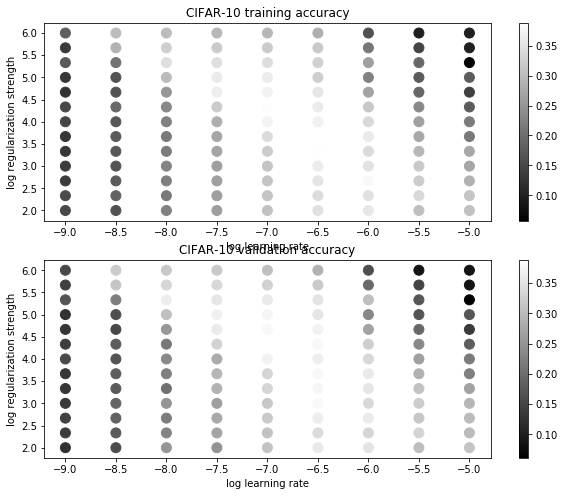

In [17]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373000


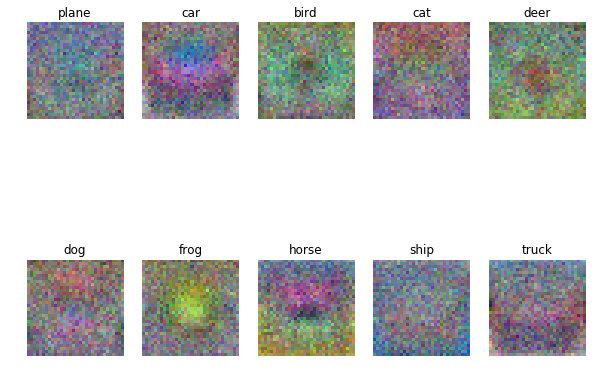

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *
- plane - there are empty space in center
- car - red probably because most cars in datasets are red
- bird - brown in center
- cat - hard to recognize
- deer - some brown in the center
- dog - brown in center, bigger the for deer
- frog - green/yellow in the center
- horse -  brown with two heads
- ship - hard to recognize
- truck - some brown with mirror
*